## Overview of the Bengali Grepheme Images

In [1]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import time, sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

sys.path.append("../tools/")
from helpers import (get_n, get_dummies, resize, image_from_char, 
                     plot_count, display_image_from_data,
                    display_writting_variety, crop_resize)

In [2]:
for dirname, _, filenames in os.walk('../../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../data/test_image_data_3.parquet
../../data/train.csv
../../data/test_image_data_1.parquet
../../data/train_image_data_2.parquet
../../data/train_image_data_3.parquet
../../data/test_image_data_2.parquet
../../data/test_image_data_0.parquet
../../data/train_image_data_0.parquet
../../data/class_map.csv
../../data/test.csv
../../data/train_image_data_1.parquet
../../data/sample_submission.csv
../../data/Kalpurush_Fonts/kalpurush-2.ttf


### Trainingset 

In [3]:
### training dataframe
DATA_FOLDER = '../../data'
train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
print(train_df.shape)
train_df.head()

(200840, 5)


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


### Testingset

In [4]:
### Testing dataframe
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
print(test_df.shape)
test_df.head()

(36, 3)


,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


### Class map

In [5]:
### Classes for three components
class_map_df = pd.read_csv(os.path.join(DATA_FOLDER, 'class_map.csv'))
print(class_map_df.shape)
class_map_df.head()

(186, 3)


,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


### Submission format

In [6]:
### Example of submission format
sample_submission_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
sample_submission_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


### Image pixels

In [7]:
train_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'train_image_data_0.parquet'))
print(train_0_df.shape)
train_0_df.head()

(50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [30]:
pixels_train_0 = 255 - train_0_df.iloc[7, 1:].values

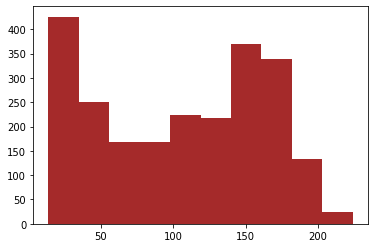

In [31]:
plt.hist(pixels_train_0[pixels_train_0 > 13], color='brown');

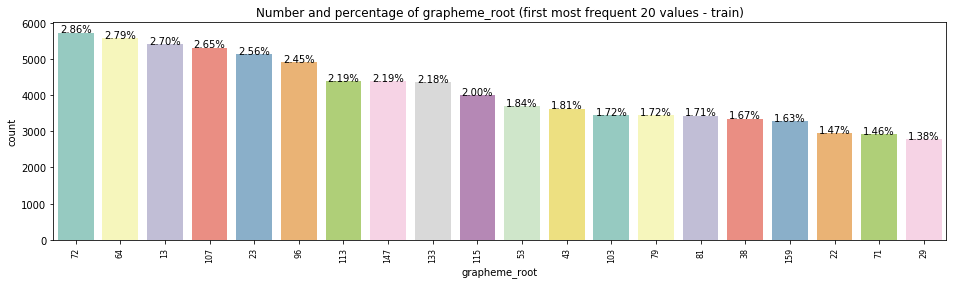

In [10]:
plot_count('grapheme_root', 'grapheme_root (first most frequent 20 values - train)', train_df, size=4)

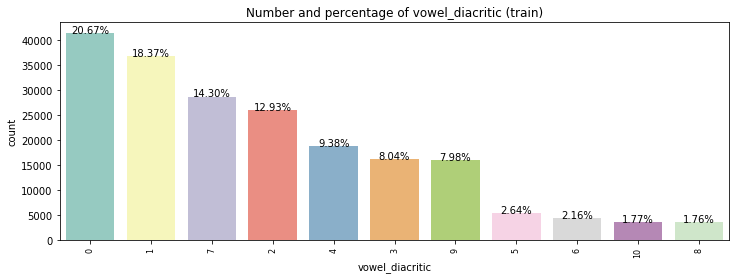

In [11]:
plot_count('vowel_diacritic', 'vowel_diacritic (train)', train_df, size=3)

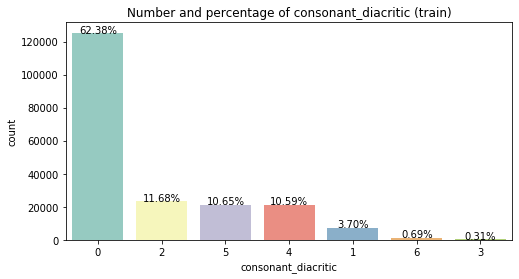

In [12]:
plot_count('consonant_diacritic', 'consonant_diacritic (train)', train_df, size=2)

### Inspecting training images

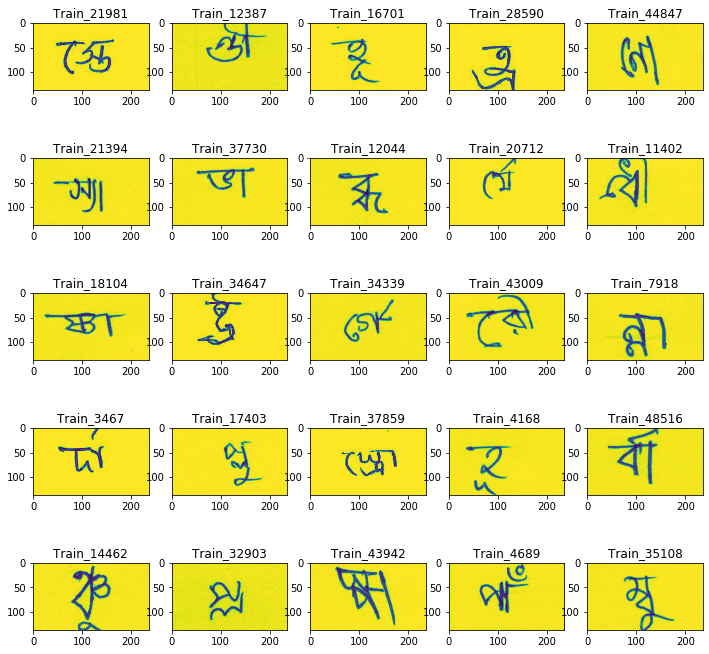

In [13]:
display_image_from_data(train_0_df.sample(25, random_state=42))

total: (163, 5)
total: (36, 32333)
grapheme: দাঁ, grapheme root: দ, vowel discritic: া, consonant diacritic: ঁ


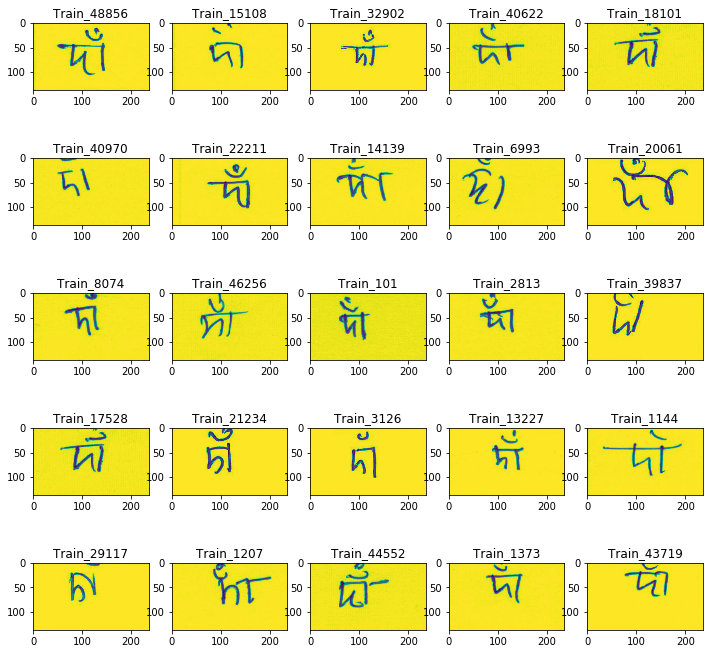

In [14]:
display_writting_variety(train_0_df,train_df, class_map_df,
                         72,1,1,5)

#### Inspecting resized images

Compare the resize methods provided in the `oepncv` package and the resize method written by [lafoss](https://www.kaggle.com/iafoss/image-preprocessing-128x128)

#### Methods by lafoss

In [41]:
HEIGHT = 137
WIDTH = 236
SIZE = 64

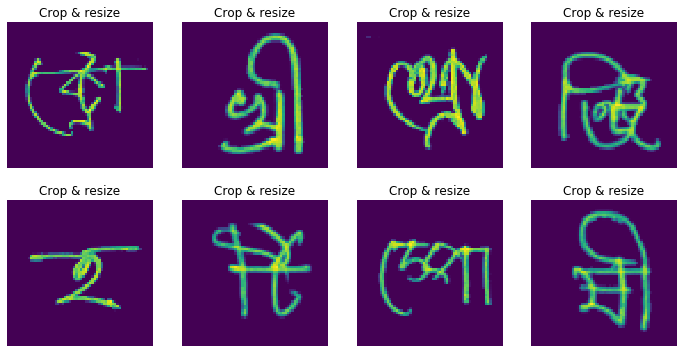

In [42]:
n_imgs = 8
fig, axs = plt.subplots(2, n_imgs//2, figsize=(n_imgs*1.5, 6))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - train_0_df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img, size=SIZE)

#     axs[idx,0].imshow(img0)
#     axs[idx,0].set_title('Original image')
#     axs[idx,0].axis('off')
#     axs[idx,1].imshow(img)
#     axs[idx,1].set_title('Crop & resize')
#     axs[idx,1].axis('off')
    axs[idx%2, idx//2].imshow(img)
    axs[idx%2, idx//2].set_title('Crop & resize')
    axs[idx%2, idx//2].axis('off')
plt.show()

(array([ 87.,  63.,  72.,  70.,  85.,  92., 131.,  93.,  51.,   6.]),
 array([ 14. ,  37.8,  61.6,  85.4, 109.2, 133. , 156.8, 180.6, 204.4,
        228.2, 252. ]),
 <a list of 10 Patch objects>)

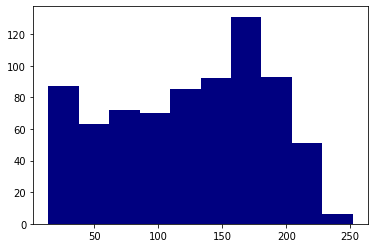

In [43]:
arrayvalues = img.reshape(-1)
plt.hist(arrayvalues[arrayvalues > 13], color='navy')

Resize methods combining data augmentation methods used in the package `albumentations` and the image processing methods in `opencv`

In [44]:
train_df = train_df.drop(['grapheme'], axis=1, inplace=False)

KeyError: "['grapheme'] not found in axis"

In [45]:
train_df_new = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{0}.parquet')[:10], 
                    train_df, on='image_id').drop(['image_id'], axis=1)
train_df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,32325,32326,32327,32328,32329,32330,32331,grapheme_root,vowel_diacritic,consonant_diacritic
0,254,253,252,253,251,252,253,251,251,253,...,253,253,253,253,253,253,251,15,9,5
1,251,244,238,245,248,246,246,247,251,252,...,255,255,255,255,255,255,254,159,0,0
2,251,250,249,250,249,245,247,252,252,252,...,252,253,253,253,253,251,249,22,3,5
3,247,247,249,253,253,252,251,251,250,250,...,254,254,253,253,252,251,252,53,2,2
4,249,248,246,246,248,244,242,242,229,225,...,255,255,255,255,255,255,255,71,9,5


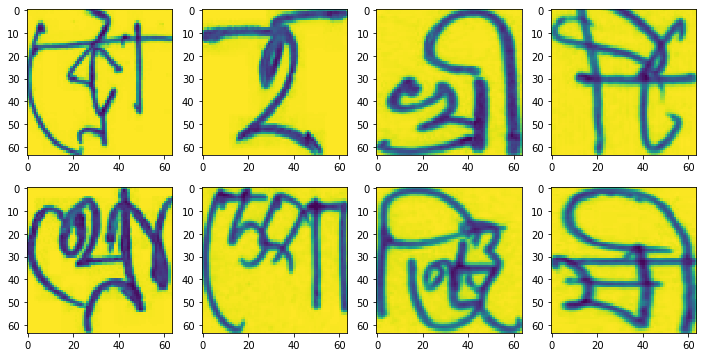

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
count=0
for row in ax:
    for col in row:
        col.imshow(resize(train_df_new.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], size=SIZE, 
                          augment=False,need_progress_bar=False)\
                   .values.reshape(-1).reshape(SIZE, SIZE).astype(np.float64))
        count += 1
plt.show()

/home/hughes/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/hughes/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([640., 319., 253., 257., 299., 314., 385., 847., 605.,  99.]),
 array([ 14. ,  37.1,  60.2,  83.3, 106.4, 129.5, 152.6, 175.7, 198.8,
        221.9, 245. ]),
 <a list of 10 Patch objects>)

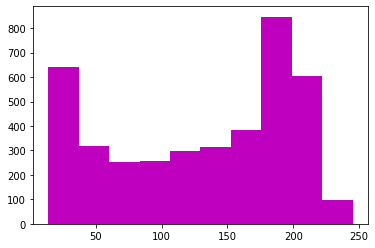

In [47]:
array_7 = 255 - resize(train_df_new.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], 
       size=128, augment=False, need_progress_bar=False)
plt.hist(array_7[array_7 > 13], color='m')